In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib.pyplot import rc_context
pd.set_option('display.max_rows', 200)
#sc.logging.print_versions() 
sc.logging.print_header()
sc.settings.verbosity = 3  
sc.settings.set_figure_params(dpi=120, color_map='viridis')

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.0 scipy==1.8.0 pandas==1.4.2 scikit-learn==0.24.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [2]:
steroid_pos_only = sc.read('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/steroid_pos_only.h5ad')

In [3]:
steroid_pos_only

AnnData object with n_obs × n_vars = 12802 × 1215
    obs: 'annotation22_ES', 'centre', 'sample_id', 'sample_id_broad', 'sample_date', 'sample_date_yr', 'pool', 'pool_broad', 'haniffa_broad_predLabel', 'orig.ident', 'merged_souporcell_cluster', 'merged_souporcell_status', 'patient_id', 'case_control', 'WHO_severity', 'sex', 'calc_age', 'discharge_date', 'date_positive_swab', 'date_first_symptoms', 'admission_date', 'ethnicity', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.8', '5_subcluster', '9_subcluster', 'annotation', 'annotation23_ES', 'annotation24_ES', 'annot3', 'annot2', 'annot1', 'leiden_0.5', 'annot4', 'wave_case_control', 'steroid_status', 'steroid_timeline', 'WHO_temp_severity', 'steroid_severity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '5_subcluster_colors', '9_subcluster', '9_subcluster_colors', 'WHO

In [4]:
#correction ##########
steroid_pos_only.obs['discharge_date'] = steroid_pos_only.obs['discharge_date'].astype('str')
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C65", "discharge_date"] = '10/06/2020'
steroid_pos_only.obs['discharge_date'] = steroid_pos_only.obs['discharge_date'].astype('category')

In [6]:
tmp = steroid_pos_only.copy()
tmp.obs['sample_date'] = tmp.obs['sample_date'].astype('object')
tmp.obs['date_first_symptoms'] = tmp.obs['date_first_symptoms'].astype('object')
tmp.obs['date_positive_swab'] = tmp.obs['date_positive_swab'].astype('object')
tmp.obs['date_first_symptoms'].replace({'NA':np.nan}, inplace = True)
tmp.obs['date_positive_swab'].replace({'NA':np.nan}, inplace = True)
time_from_first_symptoms = pd.to_datetime(tmp.obs['sample_date'], format='%d/%m/%Y') - pd.to_datetime(tmp.obs['date_first_symptoms'], format='%d/%m/%Y')
time_from_positive_swab = pd.to_datetime(tmp.obs['sample_date'], format='%d/%m/%Y') - pd.to_datetime(tmp.obs['date_positive_swab'], format='%d/%m/%Y')
days_from_first_symptoms = time_from_first_symptoms.dt.days
days_from_positive_swab = time_from_positive_swab.dt.days
days_from_first_symptoms.fillna(0, inplace = True)
days_from_positive_swab.fillna(0, inplace = True)

/tmp/ipykernel_3330/2567648701.py:11: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  days_from_first_symptoms.fillna(0, inplace = True)
/tmp/ipykernel_3330/2567648701.py:12: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  days_from_positive_swab.fillna(0, inplace = True)


In [7]:
max(days_from_first_symptoms)


18

In [8]:
min(days_from_positive_swab)


2

In [9]:
days_from_infection = [max(a,b) for a,b in zip(days_from_first_symptoms, days_from_positive_swab)]


In [10]:
max(days_from_infection)


19

In [11]:
steroid_pos_only.obs['time_from_first_symptoms'] = days_from_first_symptoms
steroid_pos_only.obs['time_from_positive_swab'] = days_from_positive_swab
steroid_pos_only.obs['time_from_infection'] = days_from_infection

In [12]:
steroid_pos_only.obs['annot4'].unique()

['CD14mono_anti_inflammatory', 'CD16mono', 'CD14mono', 'CD14mono_IFN', 'CD16mono_IFN', 'CD16mono_C1', 'Int.mono', 'CD14mono_activated']
Categories (8, object): ['CD14mono', 'CD14mono_IFN', 'CD14mono_activated', 'CD14mono_anti_inflammatory', 'CD16mono', 'CD16mono_C1', 'CD16mono_IFN', 'Int.mono']

In [13]:
# adding dates of steroid inj for each patient
steroid_pos_only.obs['steroid_date'] = 'nan'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C146", "steroid_date"] = '22/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C139", "steroid_date"] = '07/02/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C147", "steroid_date"] = '17/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C145", "steroid_date"] = '05/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C138", "steroid_date"] = '28/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C33", "steroid_date"] = '20/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C101", "steroid_date"] = '07/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C141", "steroid_date"] = '02/02/2021'



In [14]:
list(steroid_pos_only.obs['steroid_date'].unique())

['28/01/2021',
 '07/01/2021',
 '05/01/2021',
 '17/01/2021',
 '22/01/2021',
 '20/01/2021']

In [15]:
tmp = steroid_pos_only.copy()
tmp.obs['sample_date'] = tmp.obs['sample_date'].astype('object')
time_from_steroid = pd.to_datetime(tmp.obs['sample_date'], format='%d/%m/%Y') - pd.to_datetime(tmp.obs['steroid_date'], format='%d/%m/%Y')


In [16]:
days_from_steroid = time_from_steroid.dt.days

In [17]:
days_from_steroid.min()

-10

In [18]:
steroid_pos_only.obs['days_from_steroid'] = days_from_steroid

In [19]:
df =pd.crosstab(steroid_pos_only.obs['days_from_steroid'],steroid_pos_only.obs['annot4'])
df

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono
days_from_steroid,,,,,,,,
-10,57,291,9,1,51,49,267,18
-8,1,137,0,0,3,9,111,0
-6,16,312,1,16,5,21,108,1
-5,2,81,0,0,1,8,23,1
-4,0,71,0,2,0,3,3,0
-3,24,600,0,6,37,83,547,22
-2,137,714,2,18,37,134,187,28
-1,26,185,0,62,0,4,13,0
0,2,247,0,5,0,36,42,2


In [21]:
list(steroid_pos_only.obs['patient_id'].unique())

['C138', 'C101', 'C145', 'C147', 'C146', 'C33']

# C138 

In [22]:
C138 =steroid_pos_only[steroid_pos_only.obs['patient_id'].isin(['C138'])]

In [23]:
df_138 =pd.crosstab(C138.obs['days_from_steroid'],C138.obs['annot4'],)
df_138

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono
days_from_steroid,,,,,,,,
-5,2,81,0,0,1,8,23,1
-2,137,714,2,18,37,134,187,28
0,2,247,0,5,0,36,42,2
2,33,76,0,153,0,33,0,1
5,942,59,8,348,11,59,1,14
7,119,1,1,13,8,8,0,2


In [24]:
df_138.columns = df_138.columns.add_categories(['days_from_steroid'])
df_138['days_from_steroid'] = df_138.index # making index into column
df_138

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono,days_from_steroid
days_from_steroid,,,,,,,,,
-5,2,81,0,0,1,8,23,1,-5
-2,137,714,2,18,37,134,187,28,-2
0,2,247,0,5,0,36,42,2,0
2,33,76,0,153,0,33,0,1,2
5,942,59,8,348,11,59,1,14,5
7,119,1,1,13,8,8,0,2,7


# plotting

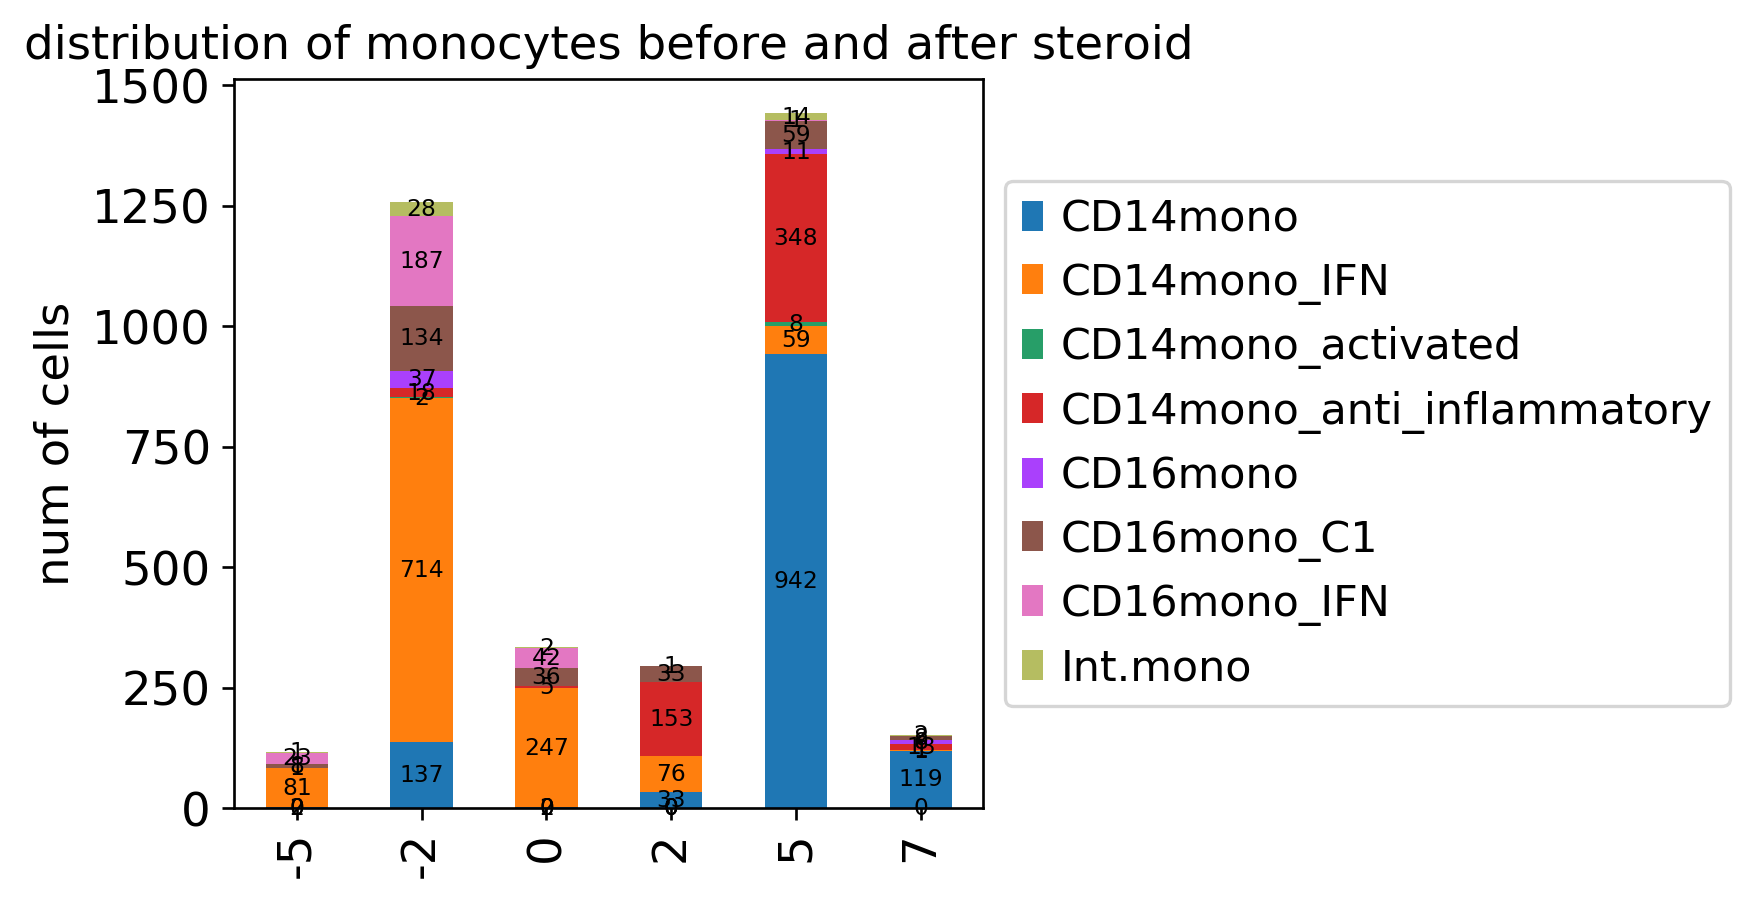

In [25]:
import matplotlib.pyplot as plt

p1=df_138.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='distribution of monocytes before and after steroid')
p1.set_ylabel('num of cells')
p1.set_xlabel('')

plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p1.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p1.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

In [26]:
cols = list(df_138.columns)
cols = cols[:-1]
df_138[cols] = df_138[cols].div(df_138[cols].sum(axis=1), axis=0).multiply(100)

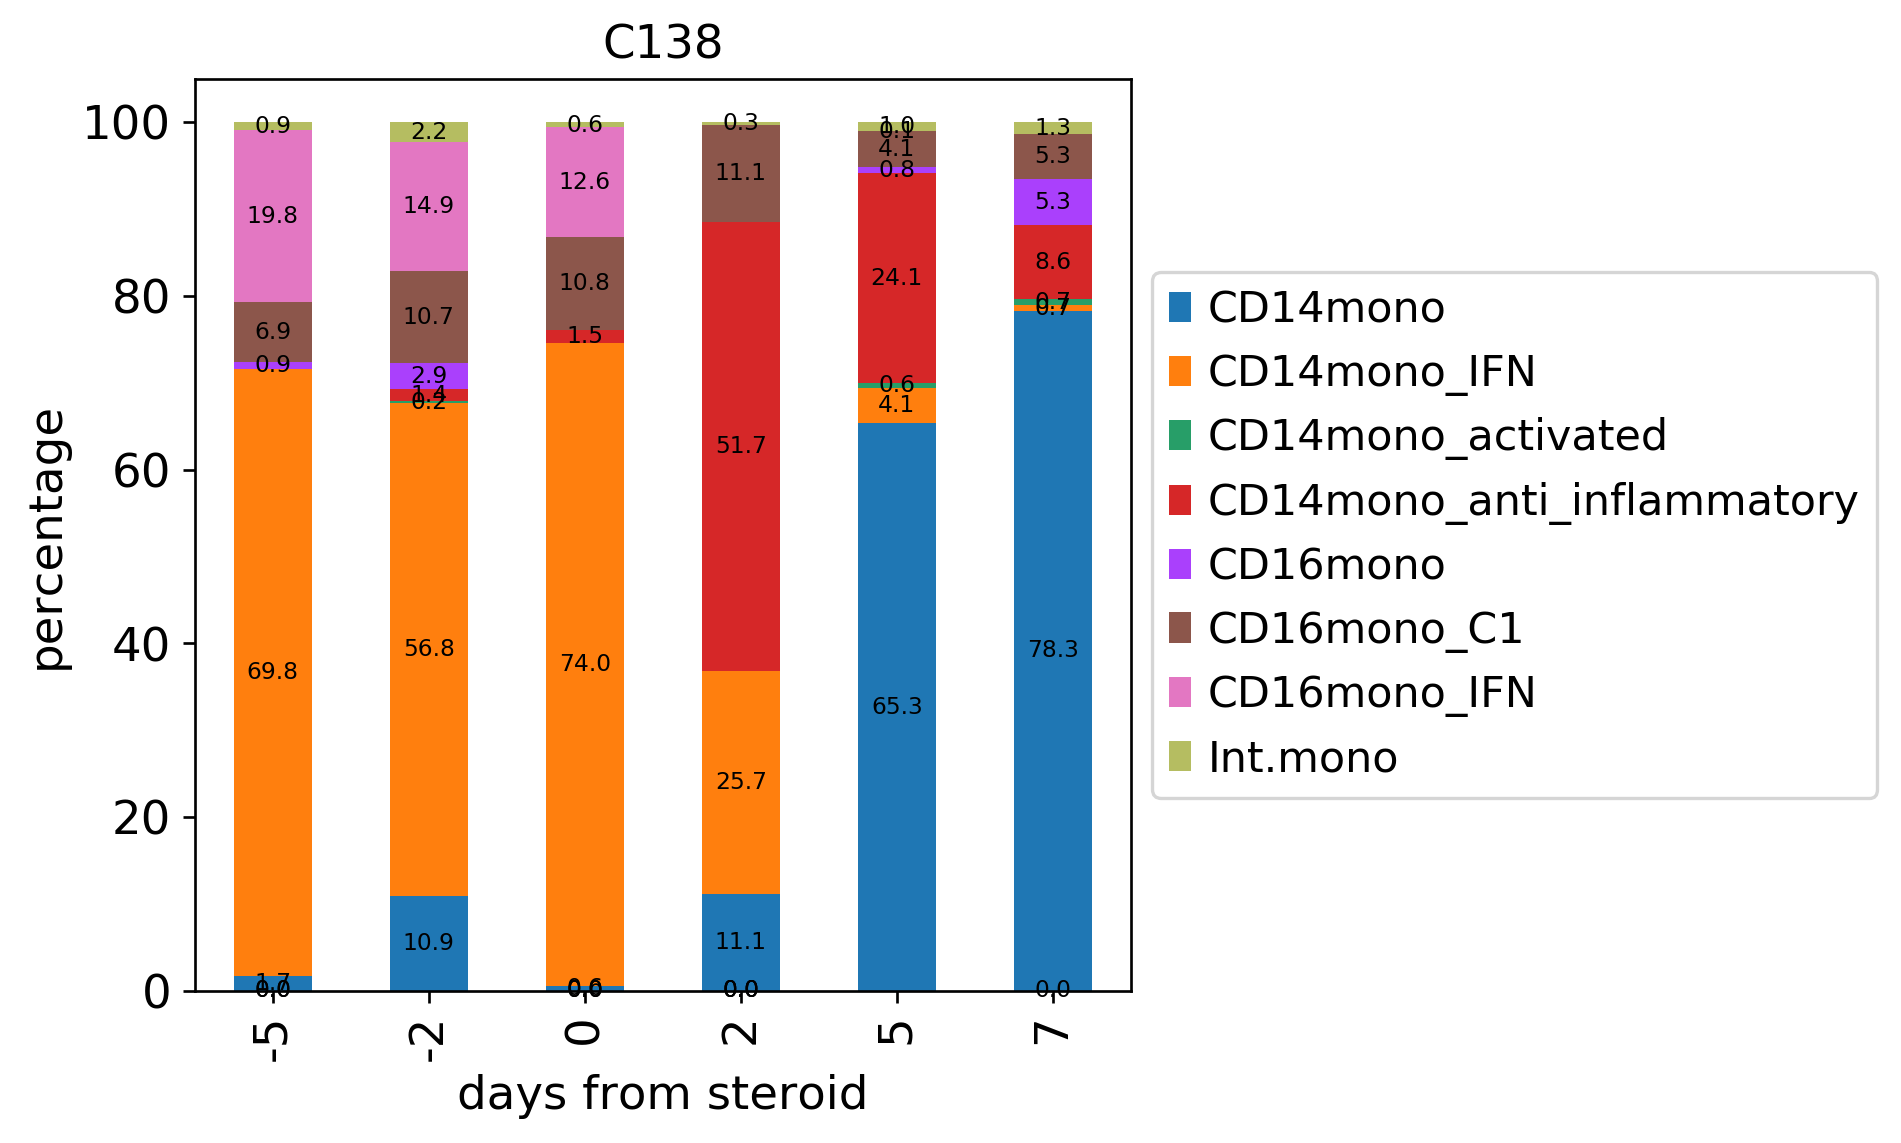

In [27]:
p2 = df_138.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='C138',figsize=(5,5))
p2.set_xlabel('days from steroid')
p2.set_ylabel('percentage')
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p2.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p2.text(x+width/2, 
            y+height/2, 
            '{:.1f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

# C101

In [28]:
C101 =steroid_pos_only[steroid_pos_only.obs['patient_id'].isin(['C101'])]

In [29]:
df_101 =pd.crosstab(C101.obs['days_from_steroid'],C101.obs['annot4'],)
df_101

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono
days_from_steroid,,,,,,,,
-1,0,41,0,0,0,1,10,0
4,34,208,0,10,0,0,6,1
6,634,212,7,26,5,1,33,28
11,136,34,0,18,8,0,2,4
13,273,48,5,10,81,1,23,17


In [30]:
df_101.columns = df_101.columns.add_categories(['days_from_steroid'])
df_101['days_from_steroid'] = df_101.index # making index into column
df_101

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono,days_from_steroid
days_from_steroid,,,,,,,,,
-1,0,41,0,0,0,1,10,0,-1
4,34,208,0,10,0,0,6,1,4
6,634,212,7,26,5,1,33,28,6
11,136,34,0,18,8,0,2,4,11
13,273,48,5,10,81,1,23,17,13


# plotting

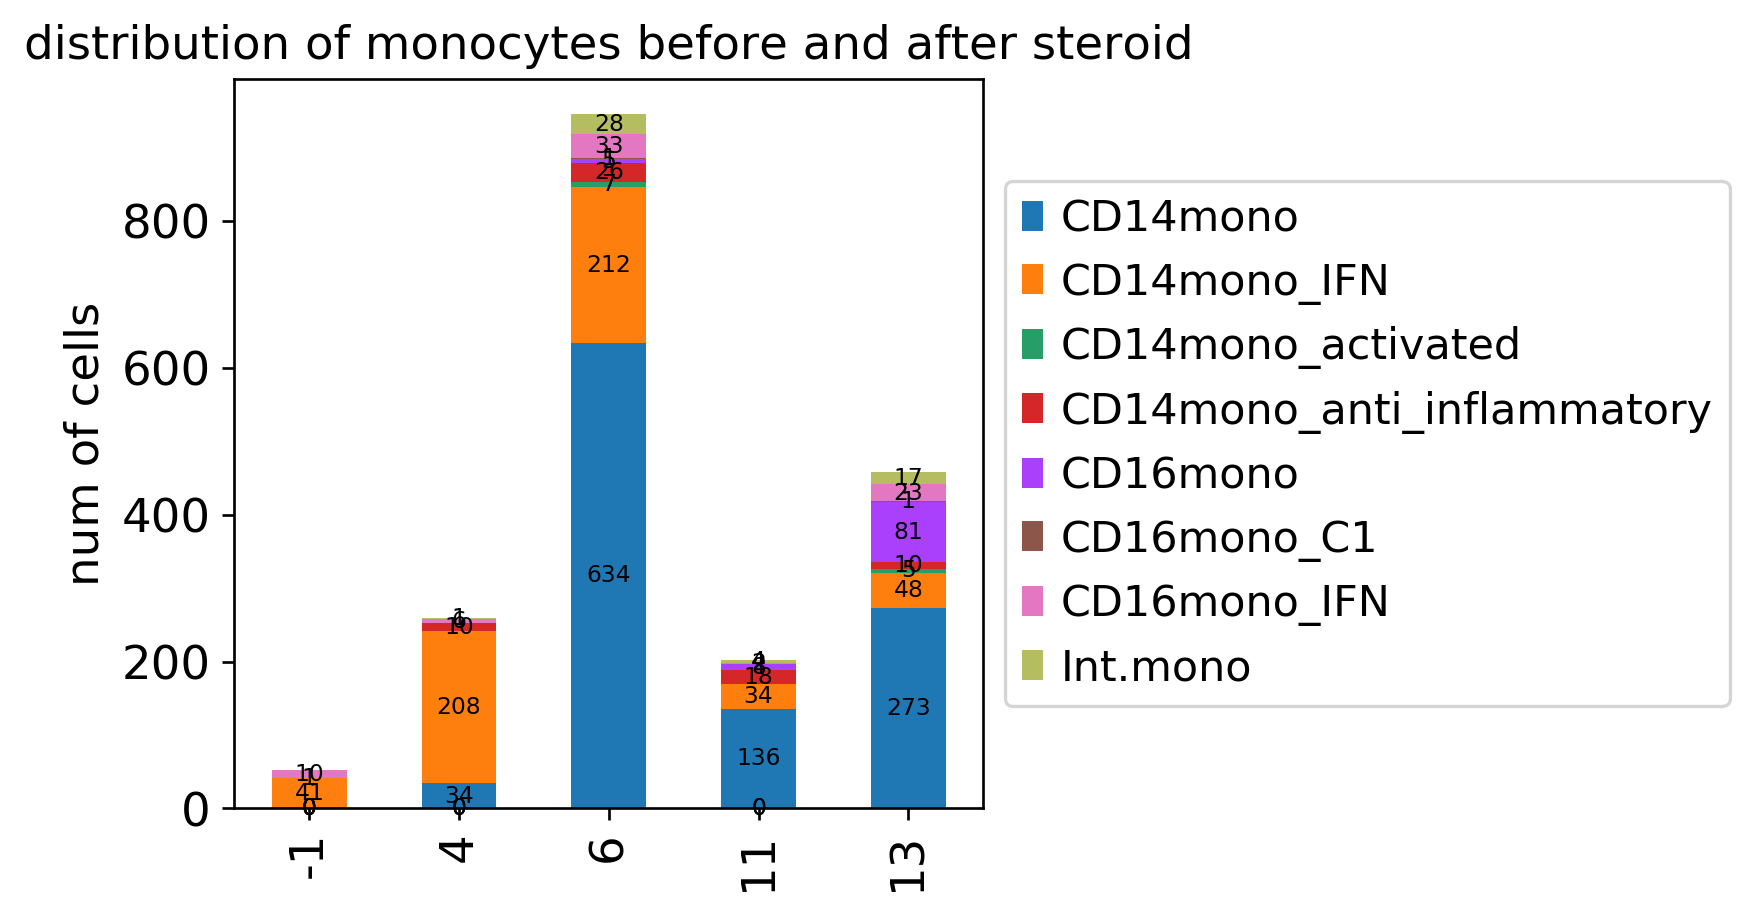

In [31]:
import matplotlib.pyplot as plt

p1=df_101.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='distribution of monocytes before and after steroid')
p1.set_ylabel('num of cells')
p1.set_xlabel('')

plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p1.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p1.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

In [32]:
cols = list(df_101.columns)
cols = cols[:-1]
df_101[cols] = df_101[cols].div(df_101[cols].sum(axis=1), axis=0).multiply(100)

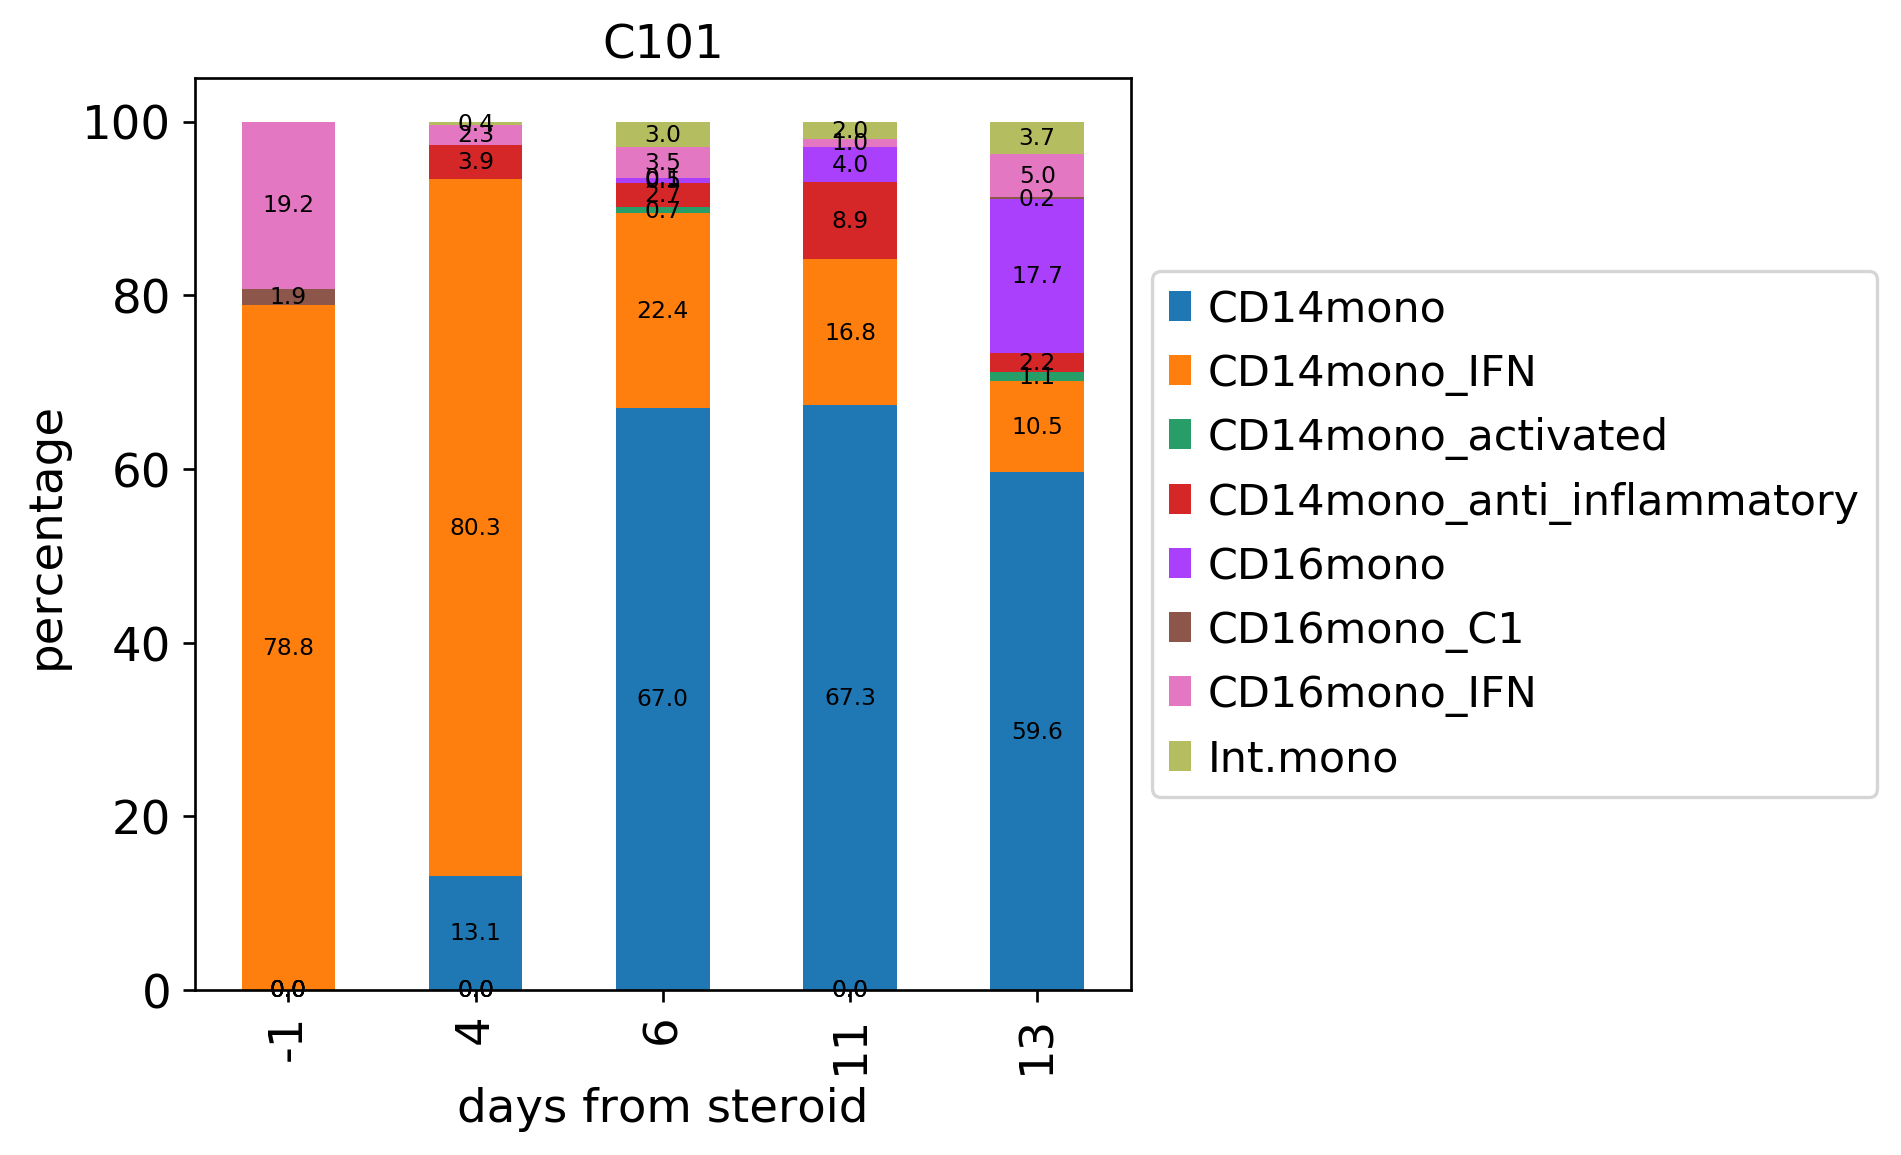

In [33]:
p2 = df_101.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='C101',figsize=(5,5))
p2.set_xlabel('days from steroid')
p2.set_ylabel('percentage')
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p2.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p2.text(x+width/2, 
            y+height/2, 
            '{:.1f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

# C145

In [37]:
C145 =steroid_pos_only[steroid_pos_only.obs['patient_id'].isin(['C145'])]

In [38]:
df_145 =pd.crosstab(C145.obs['days_from_steroid'],C145.obs['annot4'],)
df_145

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono
days_from_steroid,,,,,,,,
2,9,93,1,1,13,3,91,6
7,0,6,0,0,0,2,5,0
9,86,14,2,131,0,7,0,3
14,209,5,3,34,1,0,1,2
18,60,3,2,0,22,3,1,9


In [39]:
df_145.columns = df_145.columns.add_categories(['days_from_steroid'])
df_145['days_from_steroid'] = df_145.index # making index into column
df_145

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono,days_from_steroid
days_from_steroid,,,,,,,,,
2,9,93,1,1,13,3,91,6,2
7,0,6,0,0,0,2,5,0,7
9,86,14,2,131,0,7,0,3,9
14,209,5,3,34,1,0,1,2,14
18,60,3,2,0,22,3,1,9,18


# plotting

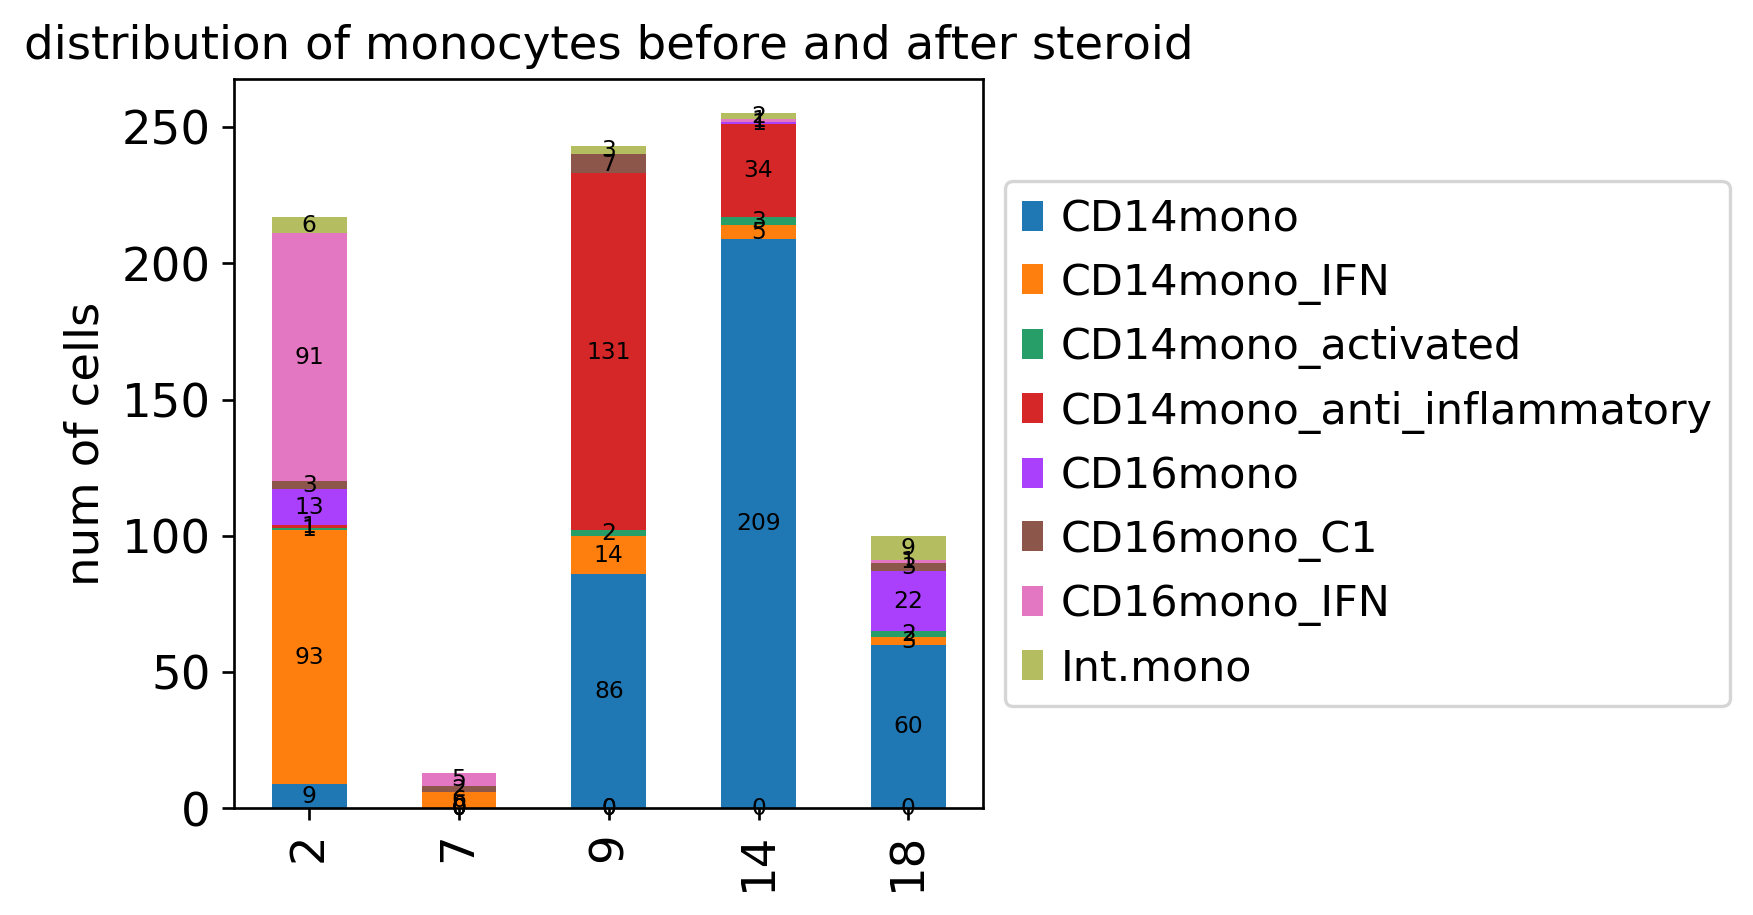

In [40]:
import matplotlib.pyplot as plt

p1=df_145.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='distribution of monocytes before and after steroid')
p1.set_ylabel('num of cells')
p1.set_xlabel('')

plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p1.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p1.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

In [41]:
cols = list(df_145.columns)
cols = cols[:-1]
df_145[cols] = df_145[cols].div(df_145[cols].sum(axis=1), axis=0).multiply(100)

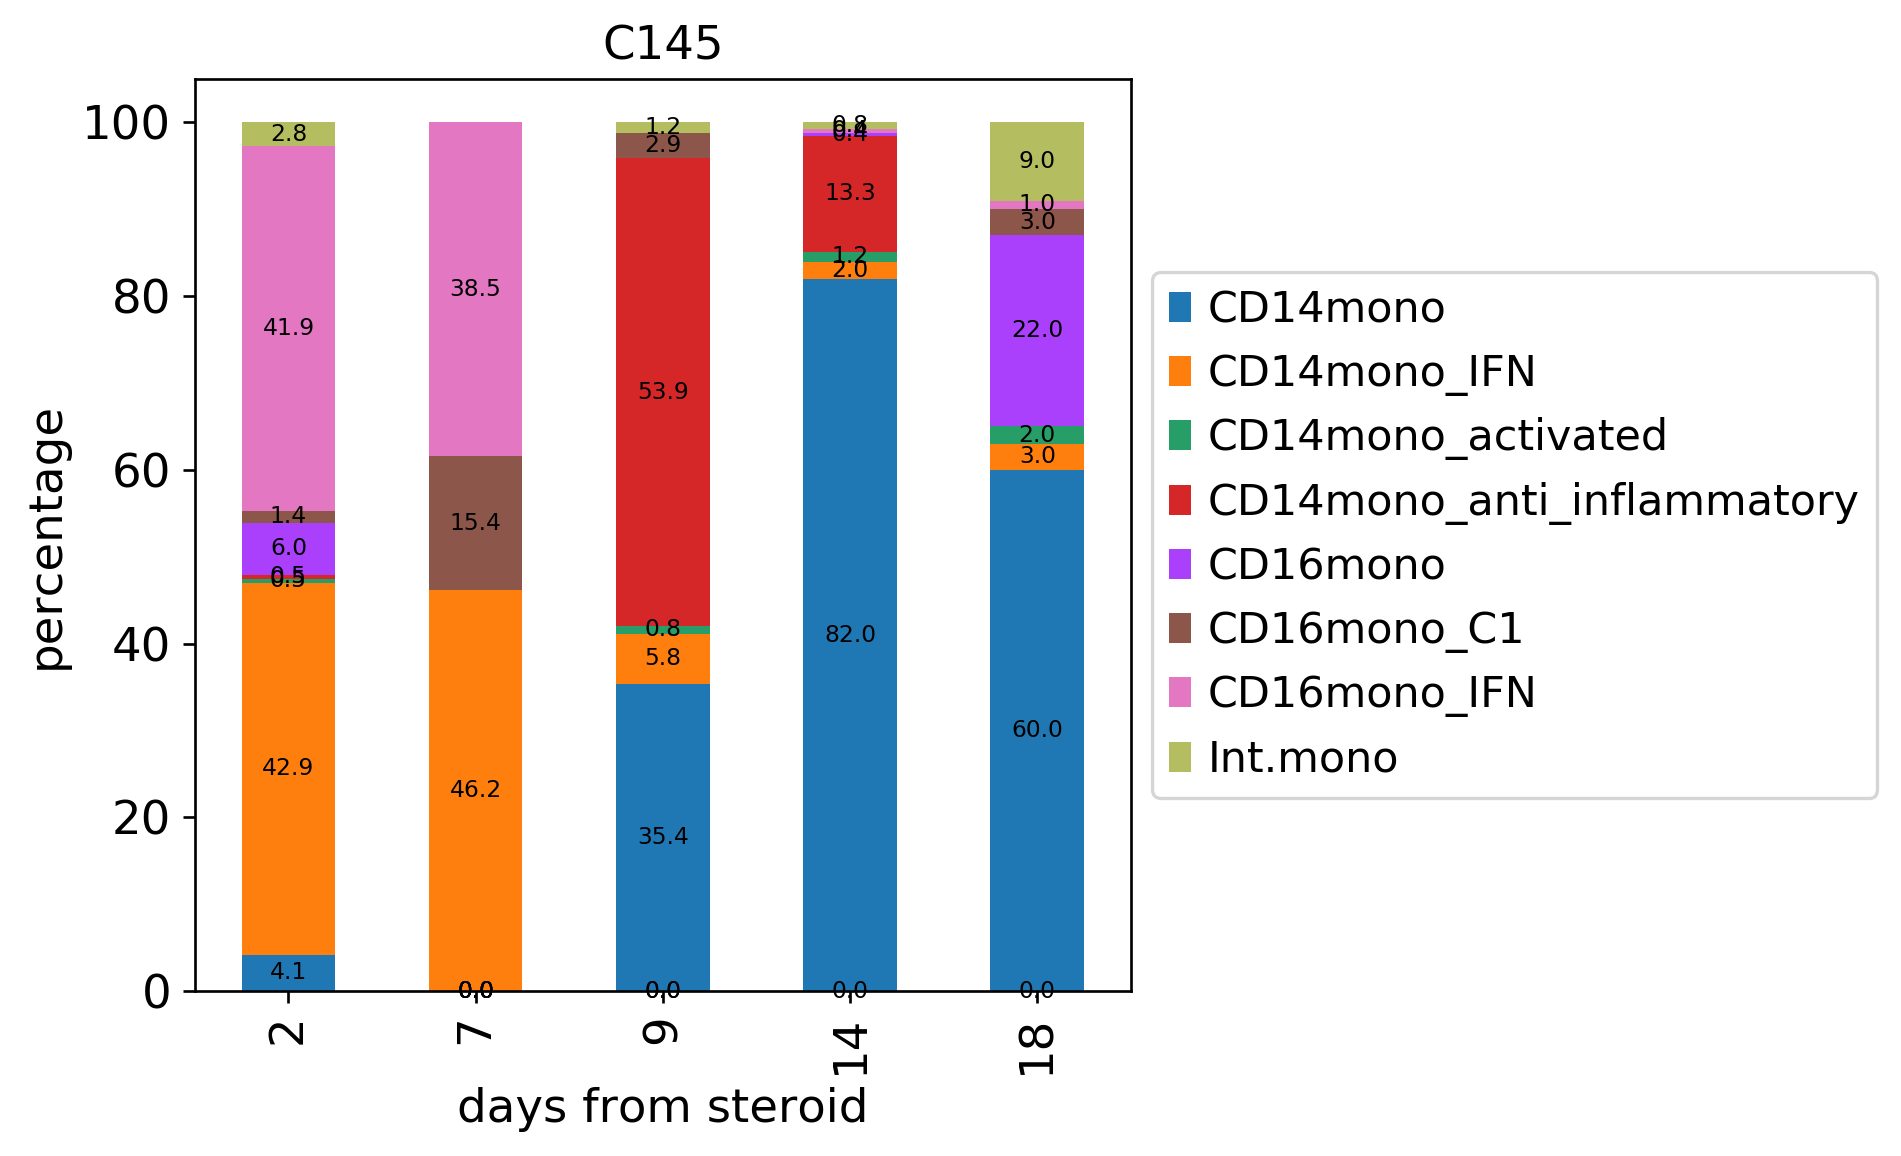

In [42]:
p2 = df_145.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='C145',figsize=(5,5))
p2.set_xlabel('days from steroid')
p2.set_ylabel('percentage')
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p2.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p2.text(x+width/2, 
            y+height/2, 
            '{:.1f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

# C147

In [43]:
C147 =steroid_pos_only[steroid_pos_only.obs['patient_id'].isin(['C147'])]

In [44]:
df_147 =pd.crosstab(C147.obs['days_from_steroid'],C147.obs['annot4'],)
df_147

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono
days_from_steroid,,,,,,,,
-3,14,497,0,0,36,73,501,19
2,2,82,0,3,0,29,68,0
6,59,23,2,160,1,8,0,2
9,505,17,3,359,4,53,1,10
11,456,84,6,107,93,96,77,35


In [45]:
df_147.columns = df_147.columns.add_categories(['days_from_steroid'])
df_147['days_from_steroid'] = df_147.index # making index into column
df_147

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono,days_from_steroid
days_from_steroid,,,,,,,,,
-3,14,497,0,0,36,73,501,19,-3
2,2,82,0,3,0,29,68,0,2
6,59,23,2,160,1,8,0,2,6
9,505,17,3,359,4,53,1,10,9
11,456,84,6,107,93,96,77,35,11


# plotting

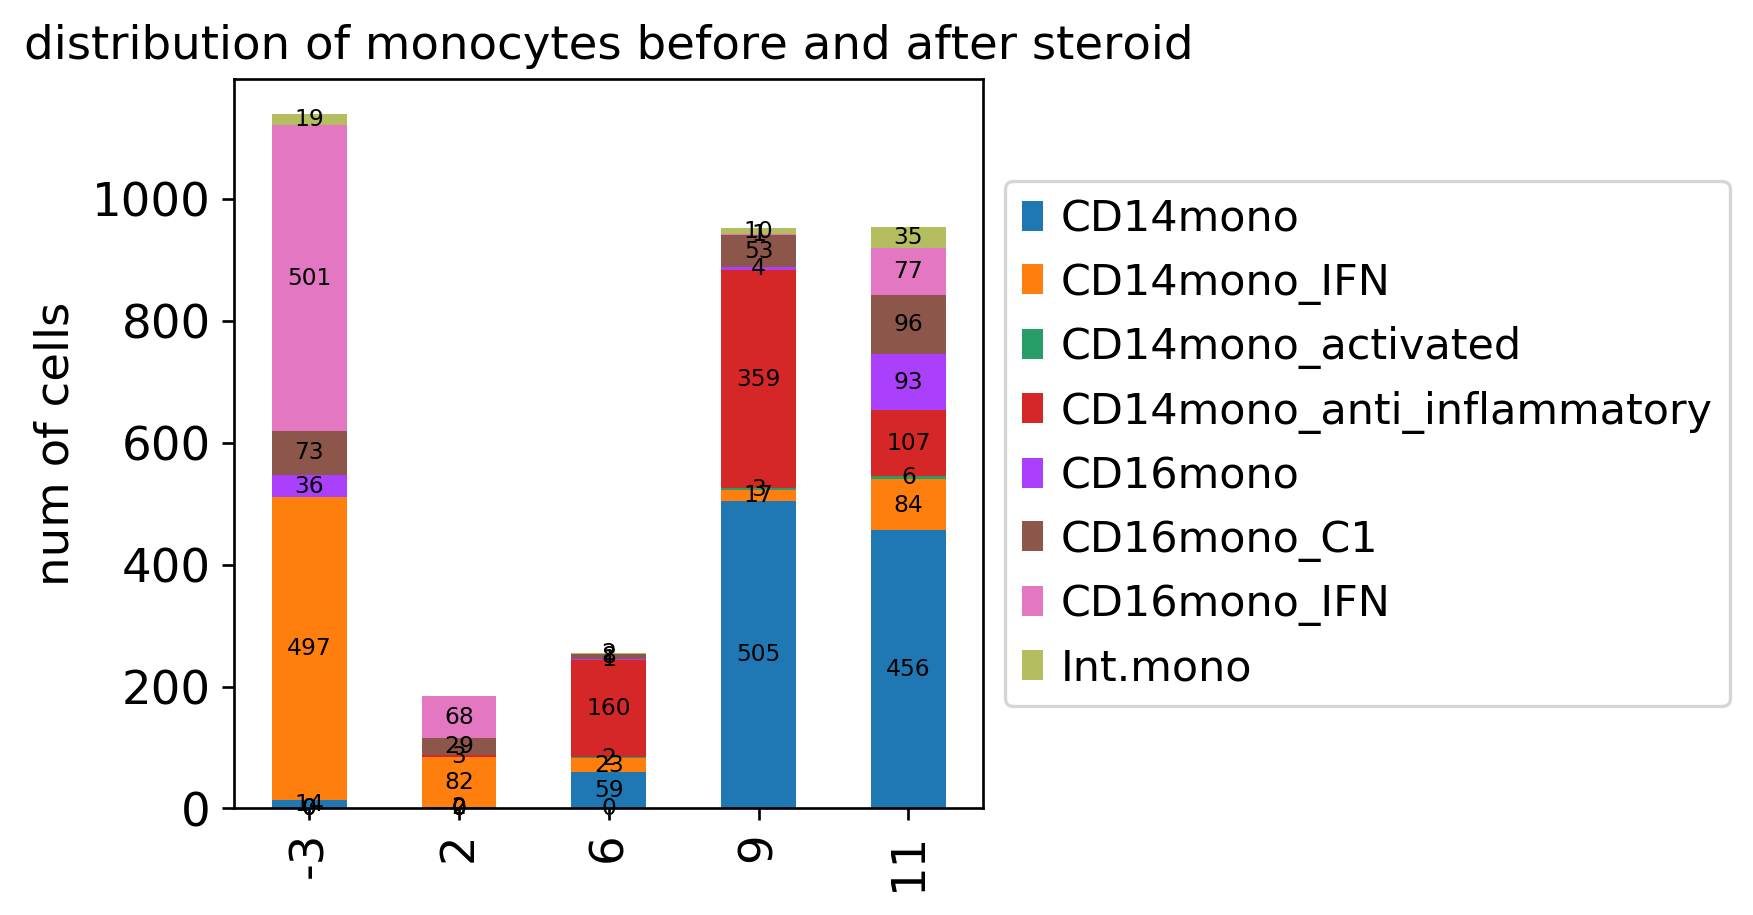

In [46]:
import matplotlib.pyplot as plt

p1=df_147.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='distribution of monocytes before and after steroid')
p1.set_ylabel('num of cells')
p1.set_xlabel('')

plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p1.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p1.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7)

In [47]:
cols = list(df_147.columns)
cols = cols[:-1]
df_147[cols] = df_147[cols].div(df_147[cols].sum(axis=1), axis=0).multiply(100)

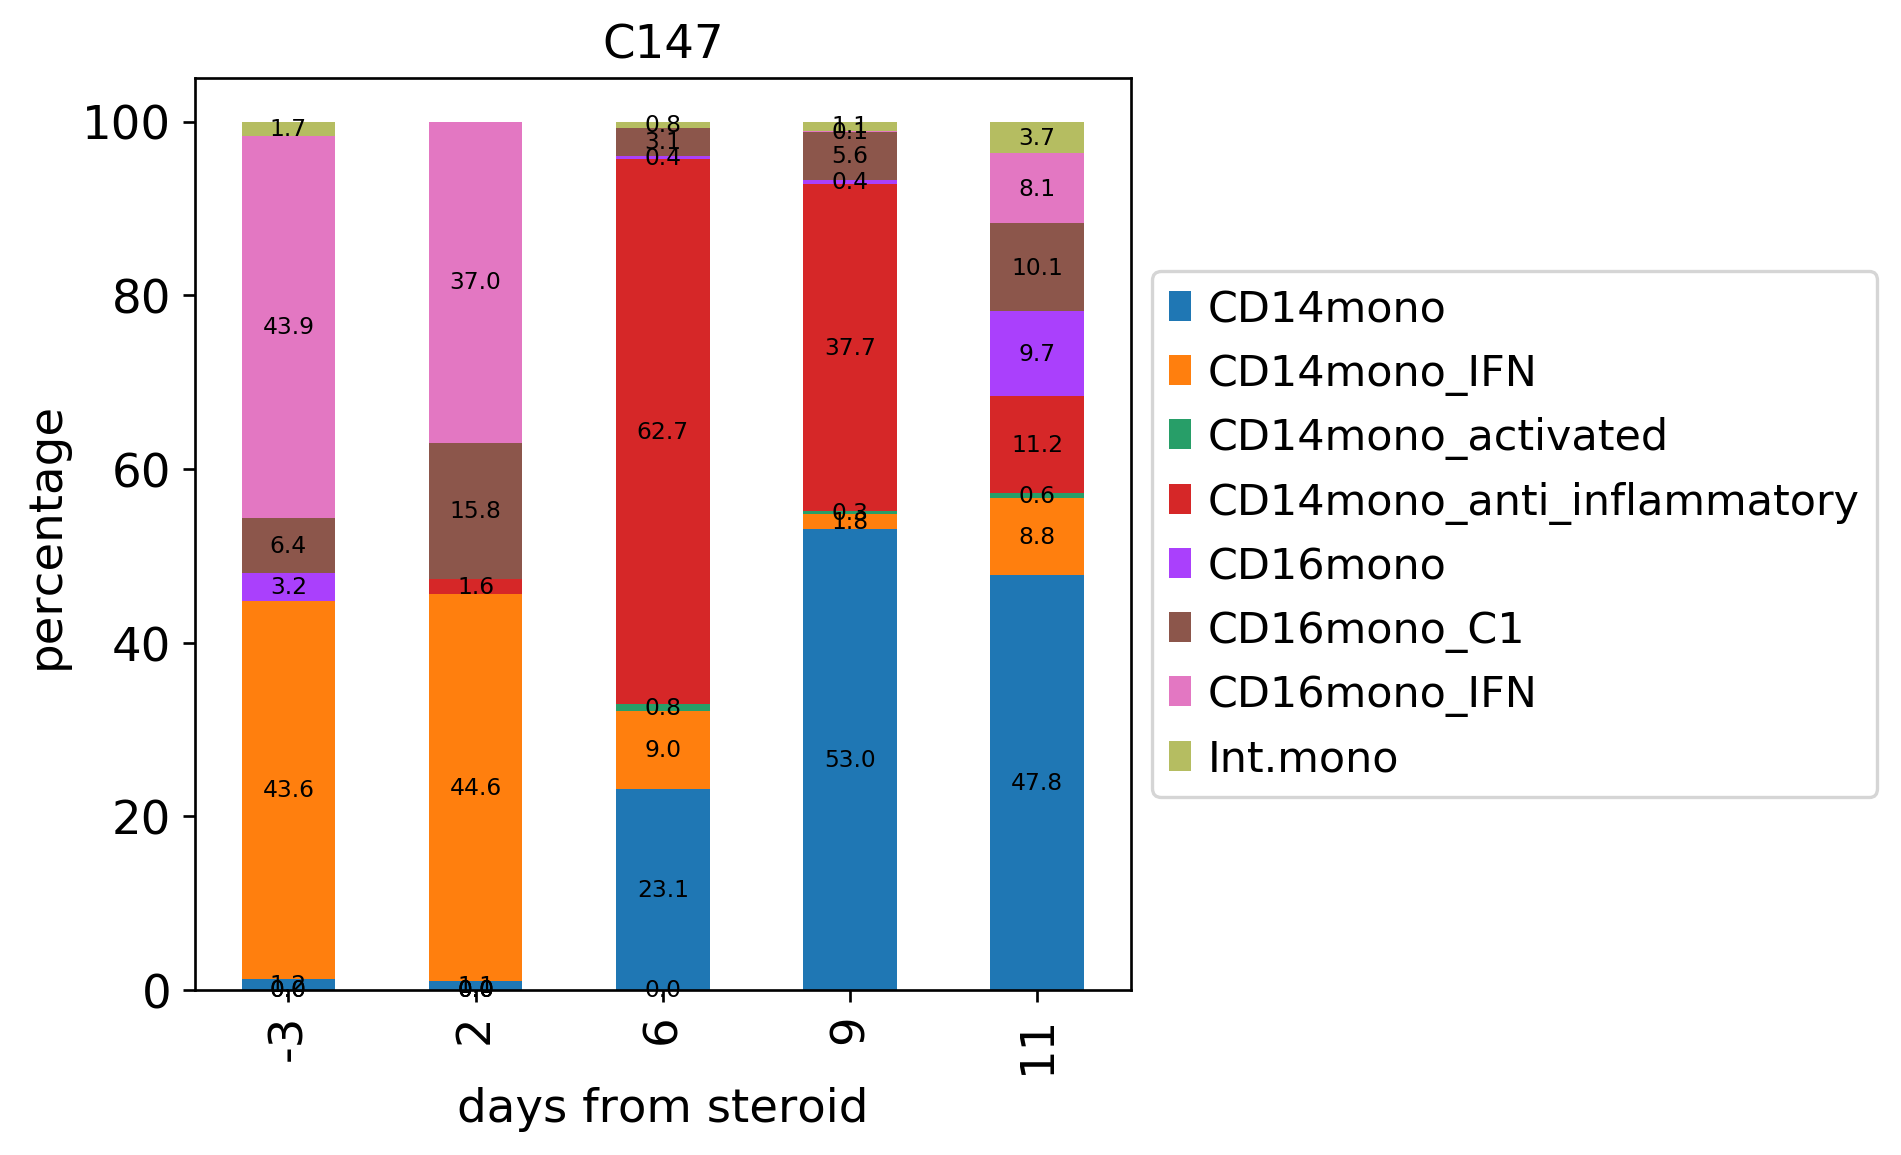

In [48]:
p2 = df_147.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='C147',figsize=(5,5))
p2.set_xlabel('days from steroid')
p2.set_ylabel('percentage')
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p2.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p2.text(x+width/2, 
            y+height/2, 
            '{:.1f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

# C146

In [49]:
C146 =steroid_pos_only[steroid_pos_only.obs['patient_id'].isin(['C146'])]

In [50]:
df_146 =pd.crosstab(C146.obs['days_from_steroid'],C146.obs['annot4'],)
df_146

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono
days_from_steroid,,,,,,,,
-10,57,291,9,1,51,49,267,18
-8,1,137,0,0,3,9,111,0
-6,0,19,0,0,0,1,5,0
-3,10,103,0,6,1,10,46,3
1,10,5,0,50,2,2,0,0
5,220,56,1,39,12,14,4,1


In [51]:
df_146.columns = df_146.columns.add_categories(['days_from_steroid'])
df_146['days_from_steroid'] = df_146.index # making index into column
df_146

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono,days_from_steroid
days_from_steroid,,,,,,,,,
-10,57,291,9,1,51,49,267,18,-10
-8,1,137,0,0,3,9,111,0,-8
-6,0,19,0,0,0,1,5,0,-6
-3,10,103,0,6,1,10,46,3,-3
1,10,5,0,50,2,2,0,0,1
5,220,56,1,39,12,14,4,1,5


# plotting

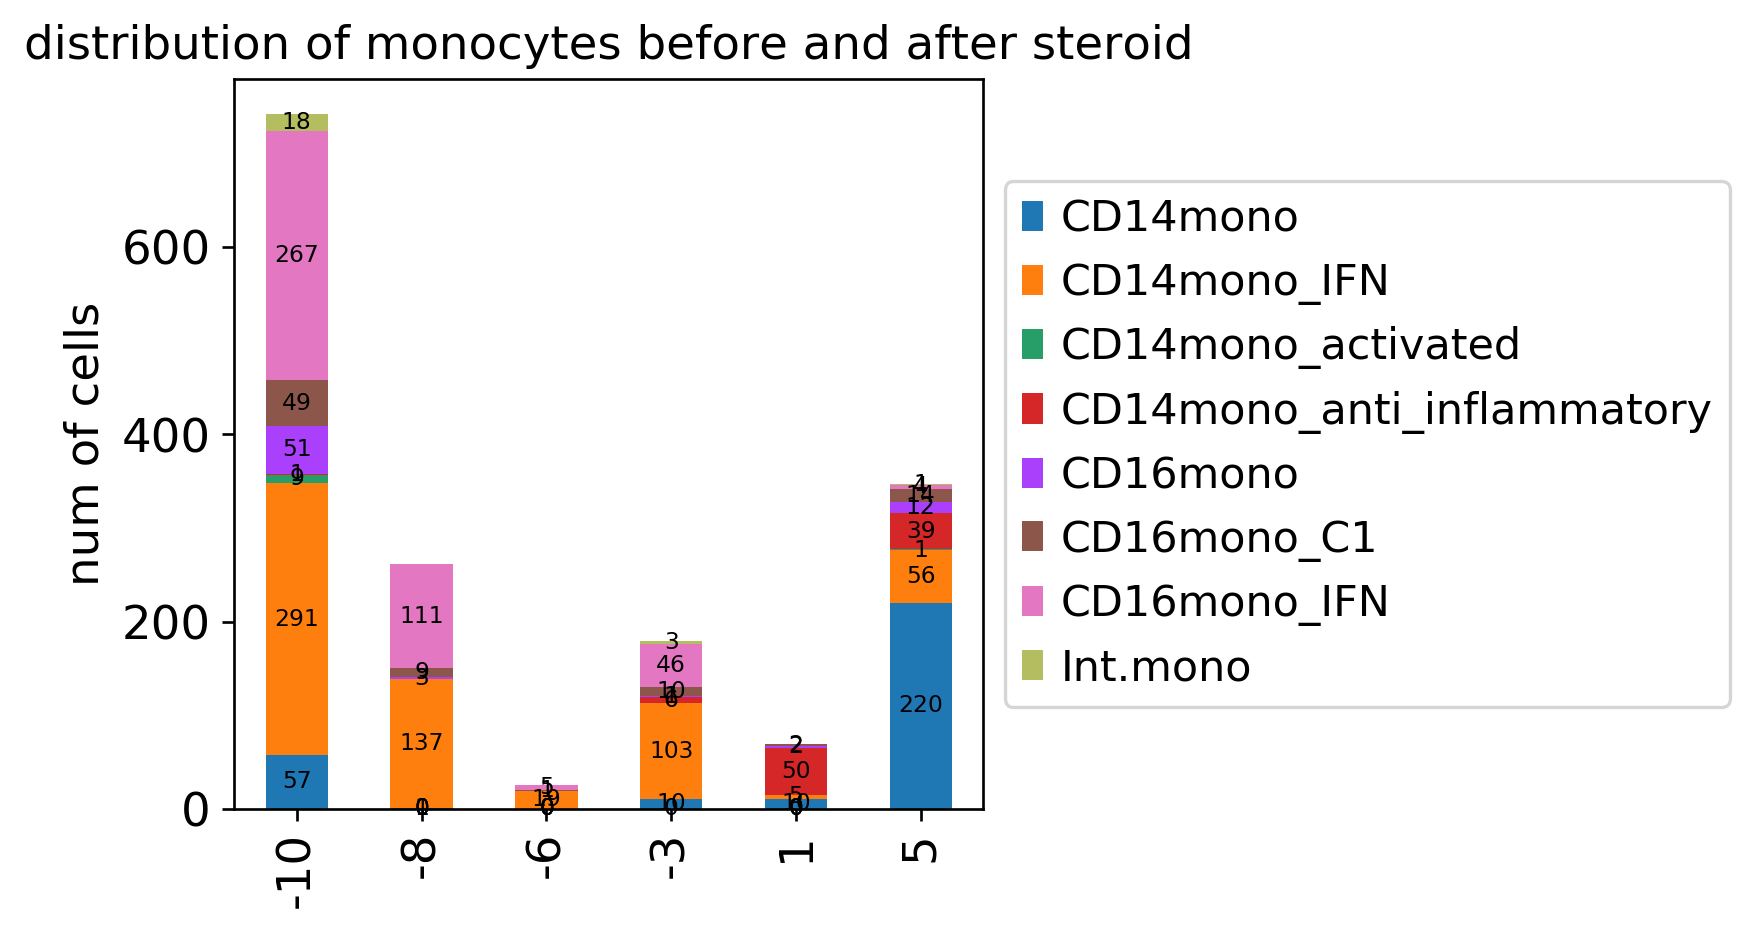

In [52]:
import matplotlib.pyplot as plt

p1=df_146.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='distribution of monocytes before and after steroid')
p1.set_ylabel('num of cells')
p1.set_xlabel('')

plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p1.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p1.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7)

In [53]:
cols = list(df_146.columns)
cols = cols[:-1]
df_146[cols] = df_146[cols].div(df_146[cols].sum(axis=1), axis=0).multiply(100)

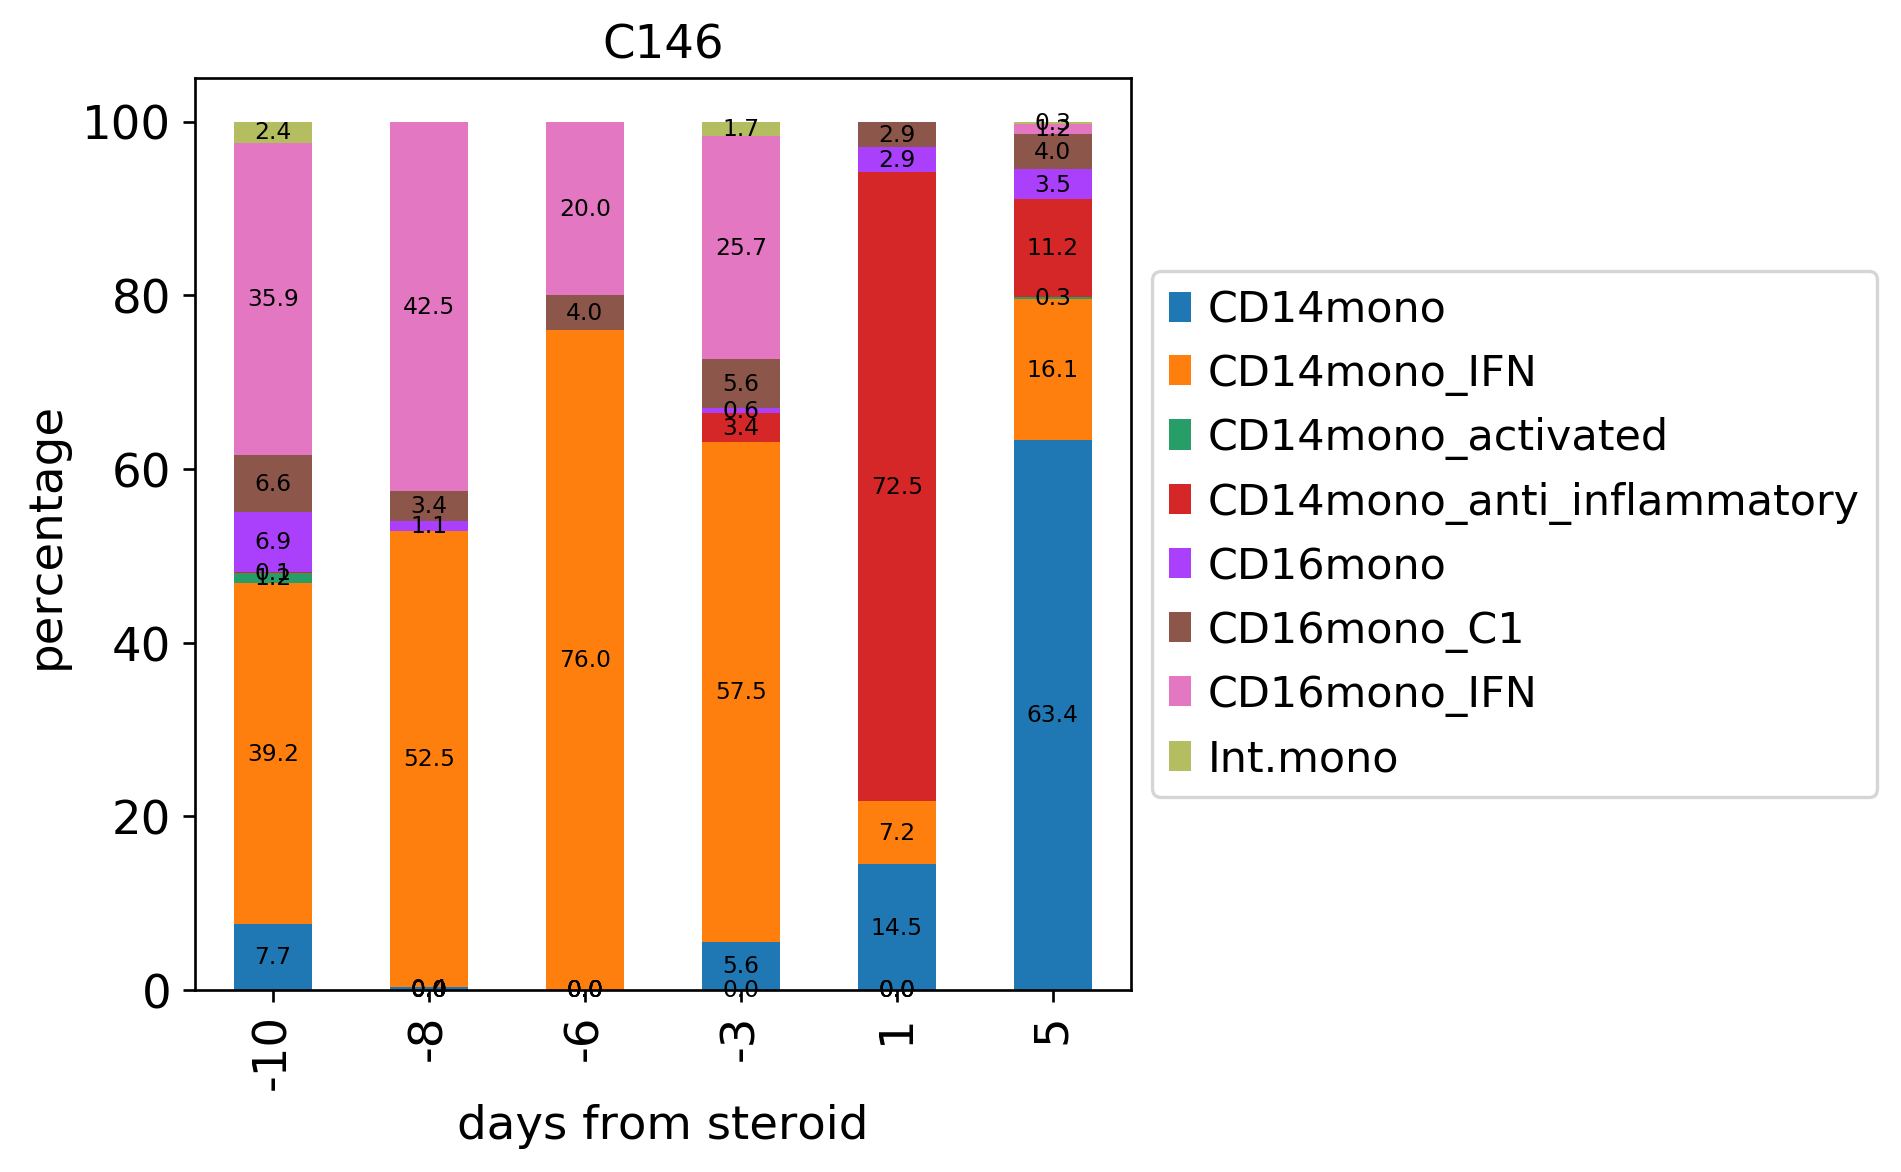

In [54]:
p2 = df_146.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='C146',figsize=(5,5))
p2.set_xlabel('days from steroid')
p2.set_ylabel('percentage')
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p2.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p2.text(x+width/2, 
            y+height/2, 
            '{:.1f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

# C33

In [55]:
C33 =steroid_pos_only[steroid_pos_only.obs['patient_id'].isin(['C33'])]

In [57]:
df_33 =pd.crosstab(C33.obs['days_from_steroid'],C33.obs['annot4'],)
df_33

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono
days_from_steroid,,,,,,,,
-6,16,293,1,16,5,20,103,1
-4,0,71,0,2,0,3,3,0
-1,26,144,0,62,0,3,3,0
6,195,140,3,214,4,22,1,0


In [58]:
df_33.columns = df_33.columns.add_categories(['days_from_steroid'])
df_33['days_from_steroid'] = df_33.index # making index into column
df_33

annot4,CD14mono,CD14mono_IFN,CD14mono_activated,CD14mono_anti_inflammatory,CD16mono,CD16mono_C1,CD16mono_IFN,Int.mono,days_from_steroid
days_from_steroid,,,,,,,,,
-6,16,293,1,16,5,20,103,1,-6
-4,0,71,0,2,0,3,3,0,-4
-1,26,144,0,62,0,3,3,0,-1
6,195,140,3,214,4,22,1,0,6


# plotting

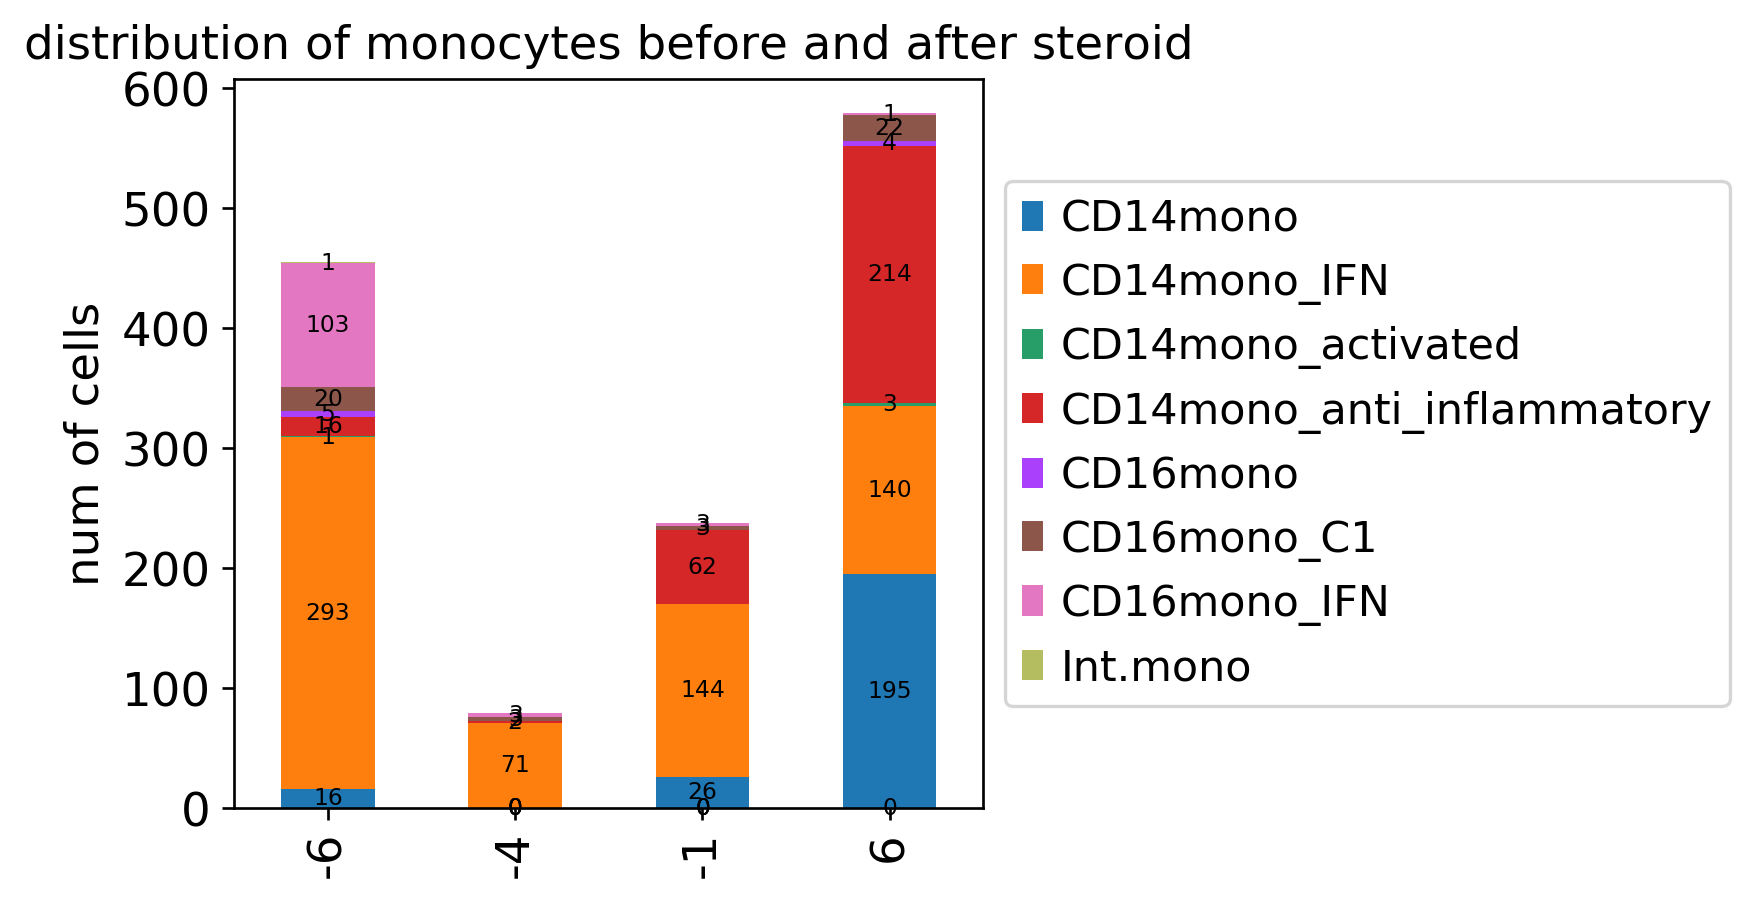

In [59]:
import matplotlib.pyplot as plt

p1=df_33.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='distribution of monocytes before and after steroid')
p1.set_ylabel('num of cells')
p1.set_xlabel('')

plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p1.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p1.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7)

In [60]:
cols = list(df_33.columns)
cols = cols[:-1]
df_33[cols] = df_33[cols].div(df_33[cols].sum(axis=1), axis=0).multiply(100)

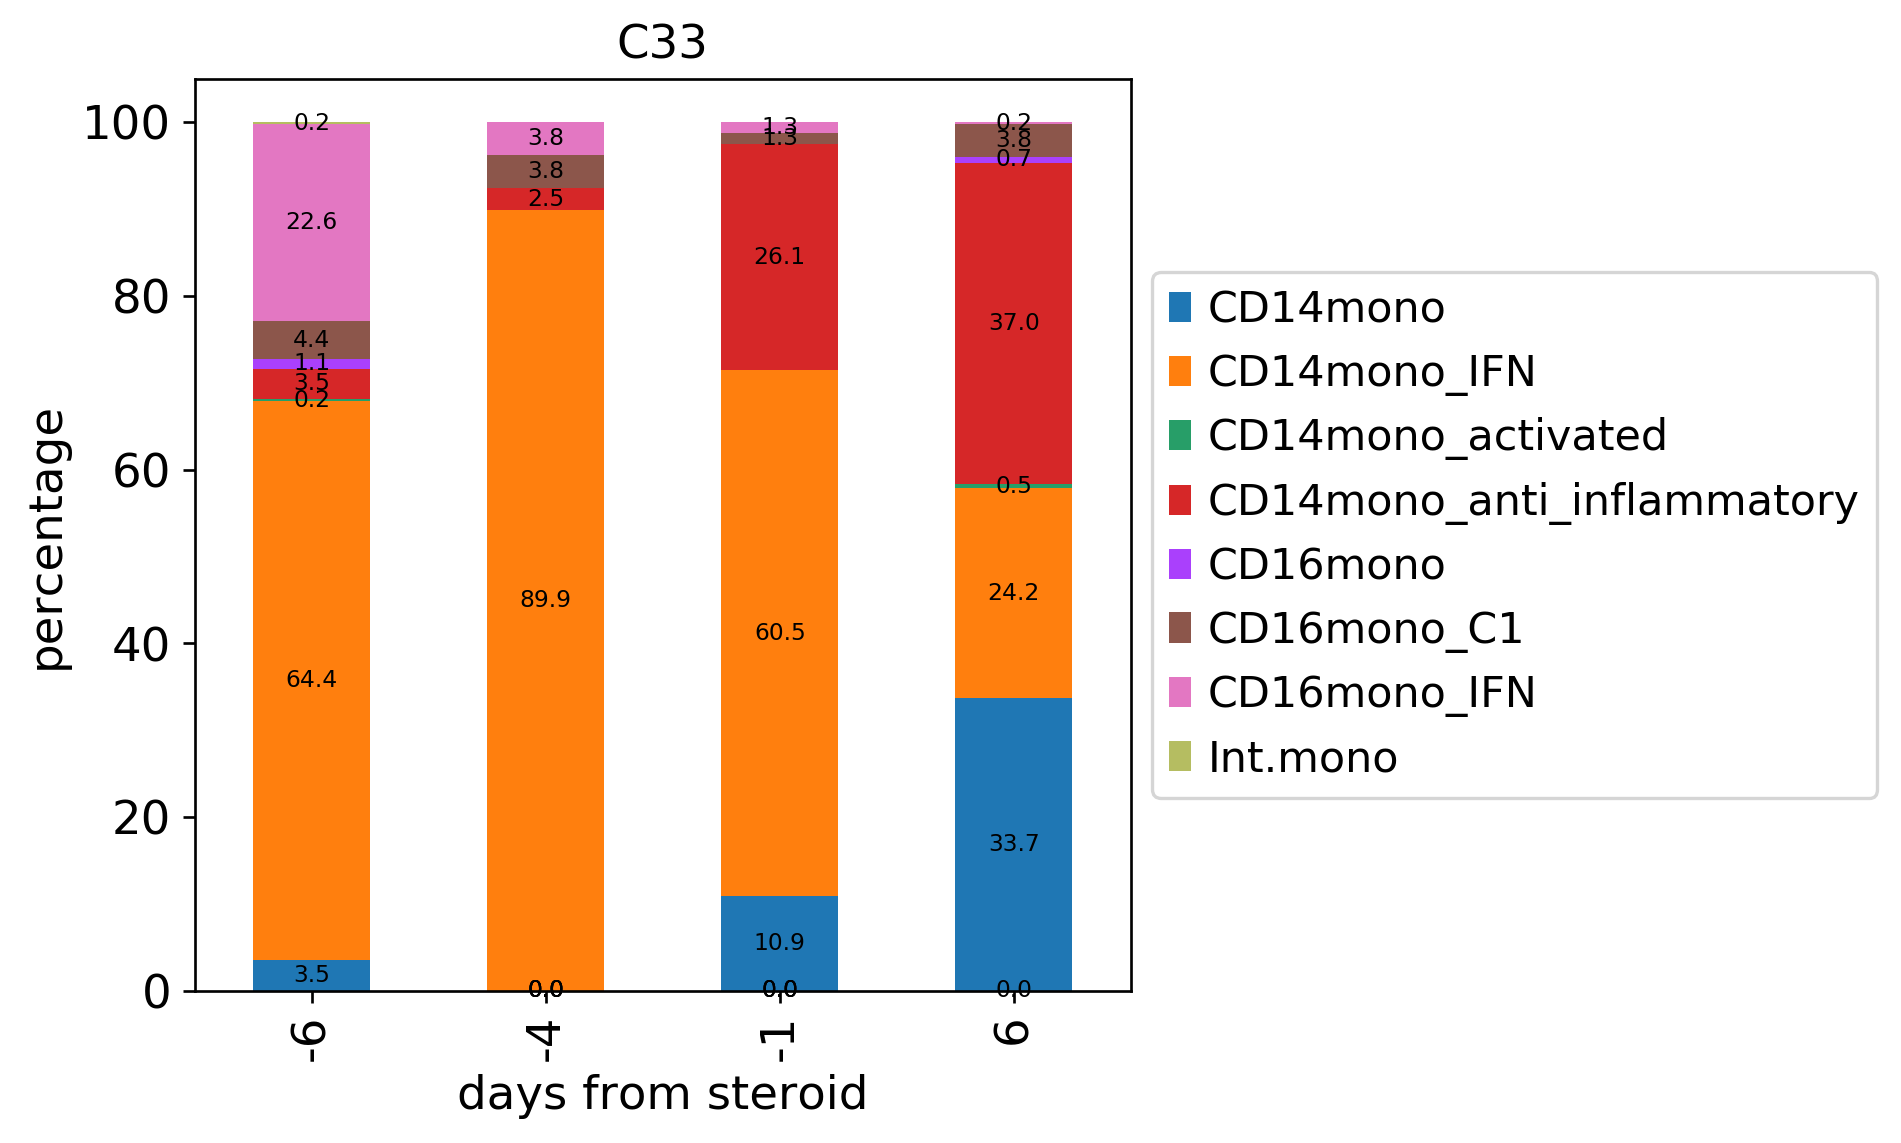

In [61]:
p2 = df_33.plot(x='days_from_steroid', kind='bar', stacked=True,
        title='C33',figsize=(5,5))
p2.set_xlabel('days from steroid')
p2.set_ylabel('percentage')
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p2.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p2.text(x+width/2, 
            y+height/2, 
            '{:.1f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7) 

# combined plot

In [62]:
steroid_pos_only.obs['patient_id'].unique()

['C138', 'C101', 'C145', 'C147', 'C146', 'C33']
Categories (6, object): ['C101', 'C138', 'C145', 'C146', 'C147', 'C33']

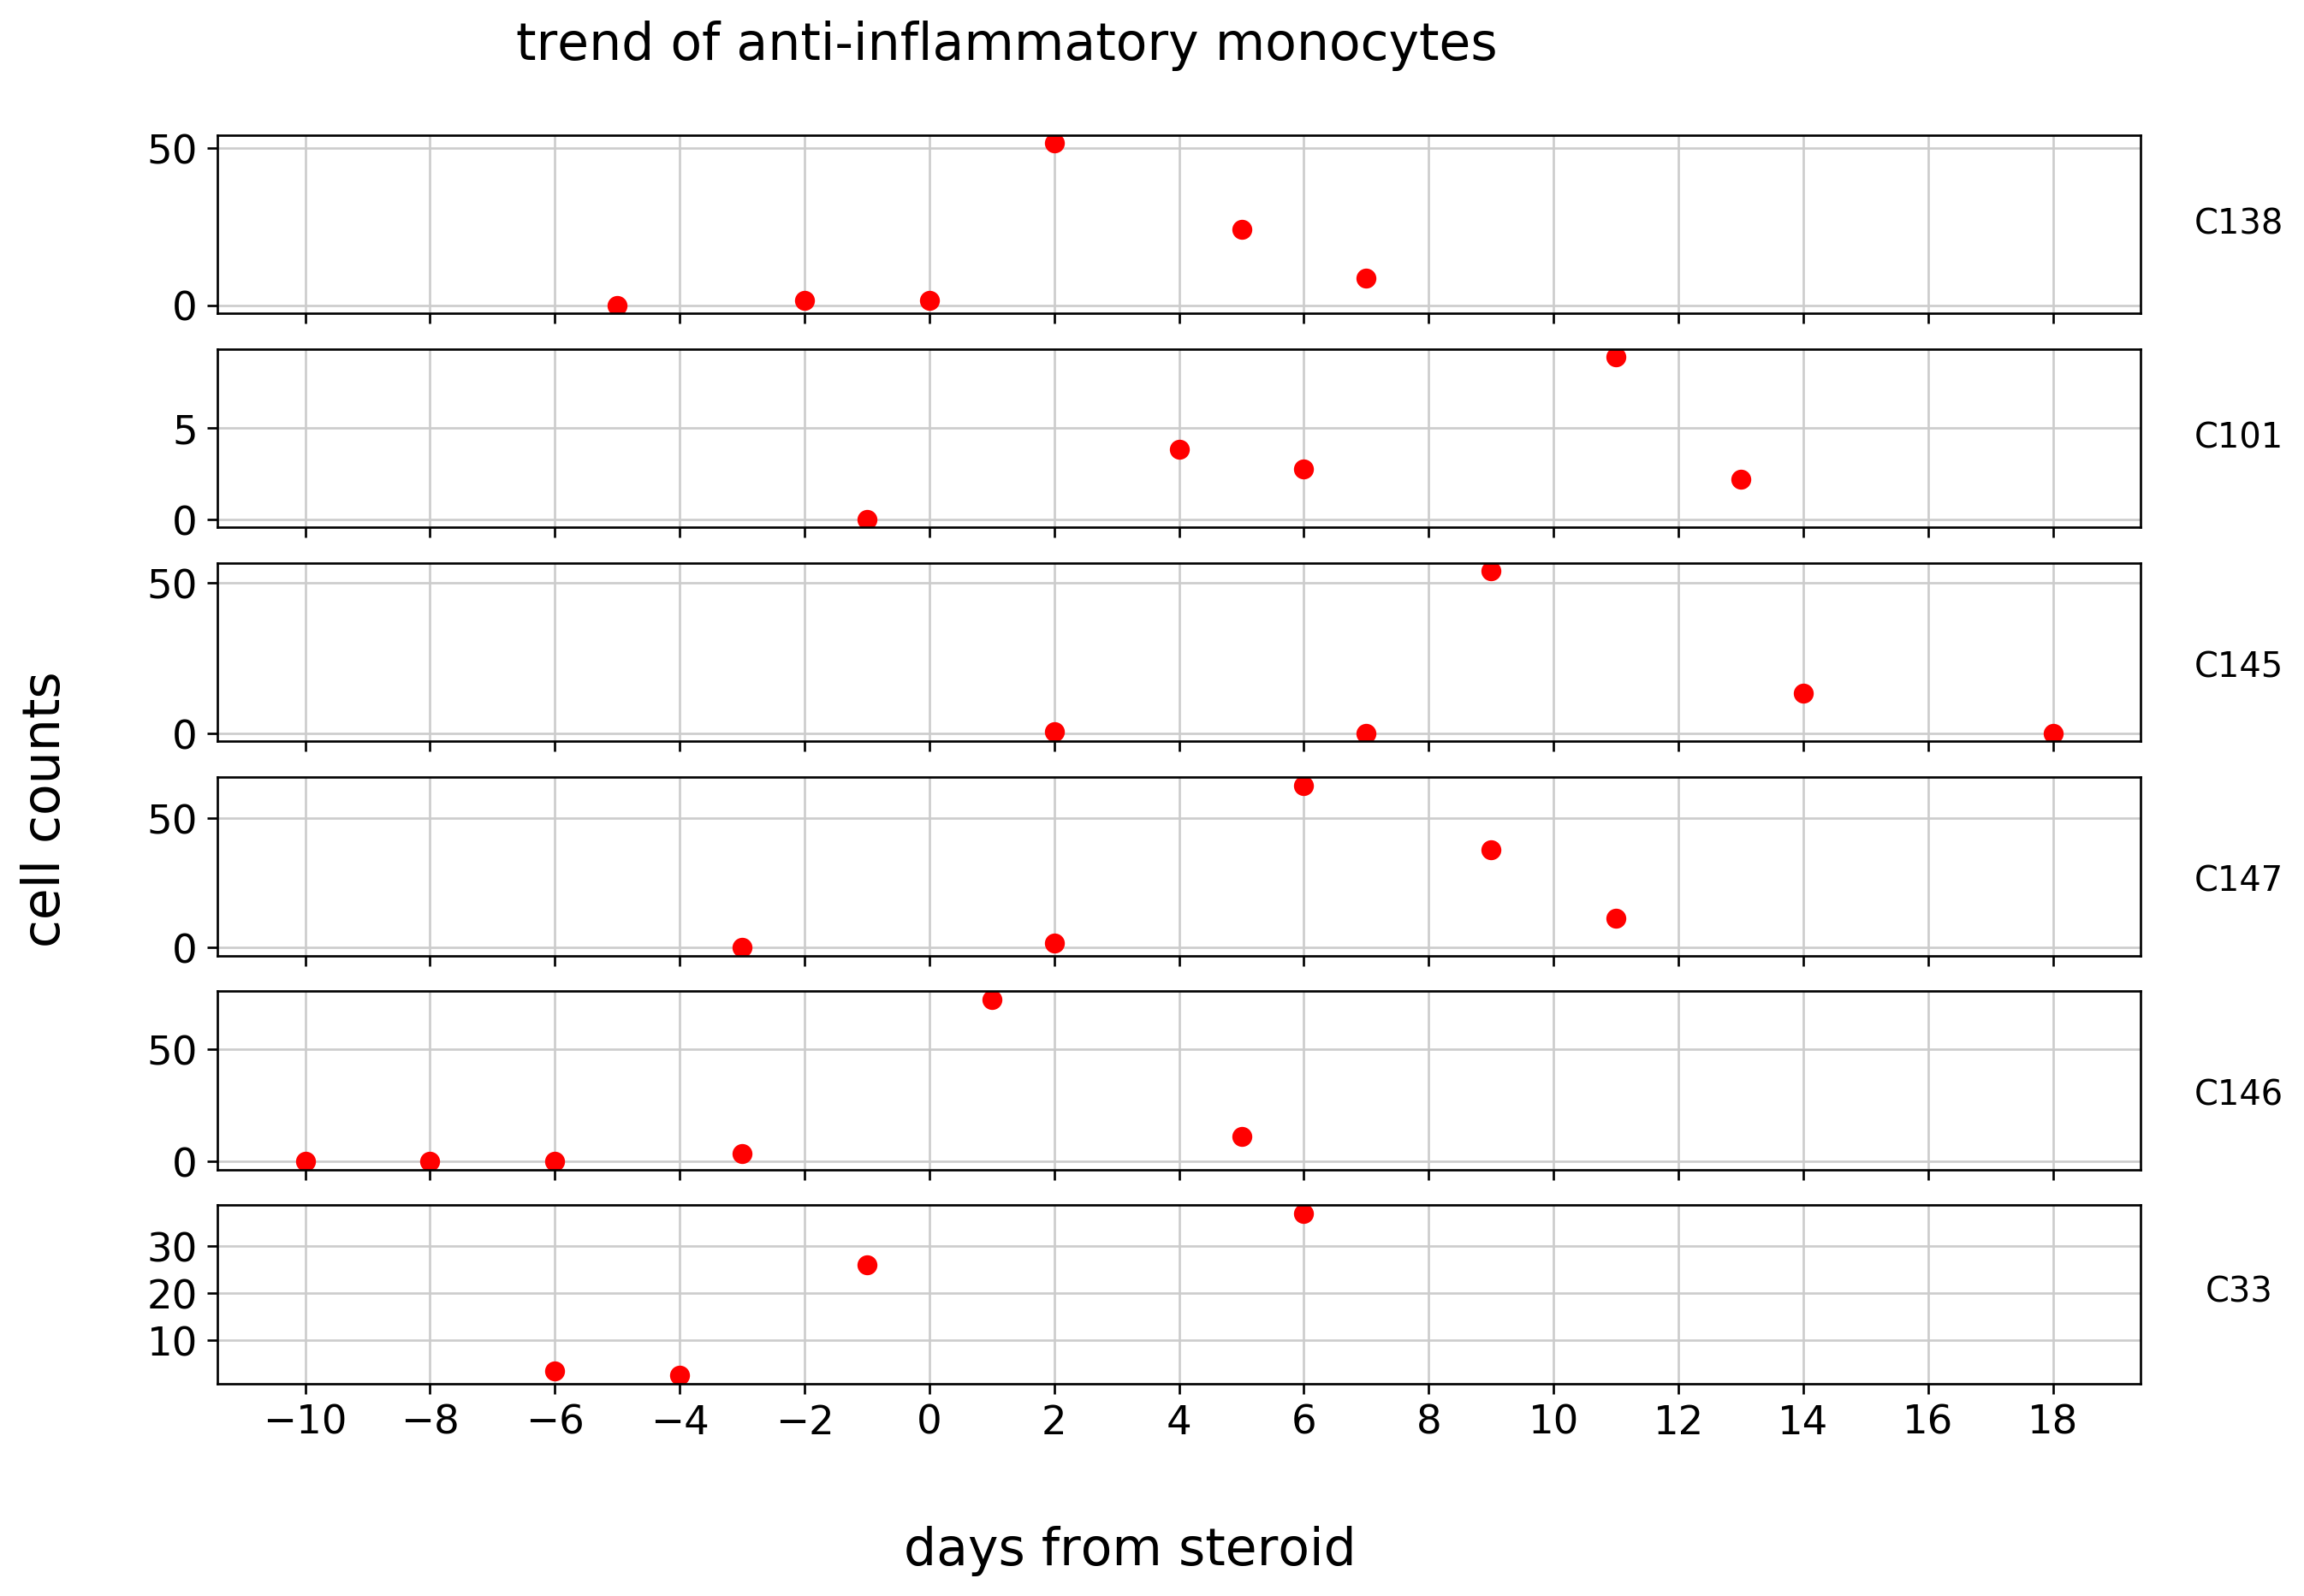

In [70]:
fig, axs = plt.subplots(nrows=6,ncols=1,sharex=True,figsize=(12,8))
fig.suptitle('trend of anti-inflammatory monocytes',fontsize=18)
axs[0].set_xticks(np.arange(-18,19,2))

axs[0].plot(df_138['days_from_steroid'],df_138['CD14mono_anti_inflammatory'],'o',color='red' )
fig.text(1, 0.85, 'C138', ha='center',fontsize=12)

axs[1].plot(df_101['days_from_steroid'],df_101['CD14mono_anti_inflammatory'],'o' ,color='red' )
fig.text(1, 0.72, 'C101', ha='center',fontsize=12)

#axs[2].plot(df_141['days_from_steroid'],df_141['CD14mono_anti_inflammatory'], 'o',color='red' )
#fig.text(1, 0.62, 'C141', ha='center',fontsize=12)

axs[2].plot(df_145['days_from_steroid'],df_145['CD14mono_anti_inflammatory'], 'o',color='red' )
fig.text(1, 0.58, 'C145', ha='center',fontsize=12)

axs[3].plot(df_147['days_from_steroid'],df_147['CD14mono_anti_inflammatory'], 'o',color='red' )
fig.text(1, 0.45, 'C147', ha='center',fontsize=12)

axs[4].plot(df_146['days_from_steroid'],df_146['CD14mono_anti_inflammatory'], 'o',color='red' )
fig.text(1, 0.32, 'C146', ha='center',fontsize=12)

axs[5].plot(df_33['days_from_steroid'],df_33['CD14mono_anti_inflammatory'], 'o',color='red' )
fig.text(1, 0.2, 'C33', ha='center',fontsize=12)


fig.text(0.55, 0.04, 'days from steroid', ha='center',fontsize=18)
fig.text(0.1, 0.5, 'cell counts', va='center', rotation='vertical',fontsize=18)
fig.savefig('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/trend_anti.png', dpi=150)